In [1]:
import pandas as pd
import numpy as np
import os 
from tqdm import tqdm
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../")

import src.biblioteca as bb
sys.path.append("../")
import src.soportecleaning as spcl

# Input files

Base data file

In [2]:
with open('../data/pickle/playlist.pickle', 'rb') as base_data:
    base_data = pickle.load(base_data)
print(base_data.shape)
base_data.head(1)

(455057, 11)


,title,rank,date,artist,url,region,chart,trend,streams,week_in_charts,times_in_charts
0,Bad and Boujee (feat. Lil Uzi Vert),1,2017-01-01,Migos,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,United States,top200,SAME_POSITION,1371493.000,429,1


LastFM extraction

In [3]:
with open('../data/pickle/lastfm.pickle', 'rb') as data_lastfm:
    data_lastfm = pickle.load(data_lastfm)
data_lastfm.drop_duplicates(inplace=True)
print(data_lastfm.drop_duplicates().shape)
data_lastfm.head(1)

(14659, 24)


,url,artist,track,artist_0,artist_1,artist_2,published_track,published,summary,content,aritist_genre_0,aritist_genre_1,aritist_genre_2,aritist_genre_3,aritist_genre_4,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,music_genre,gender,birthday_date,age
0,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,migos,bad and boujee (feat. lil uzi vert),migos,None,None,"30 Jan 2018, 04:41","26 Jun 2013, 14:20","Migos is a rap trio-group from Lawrenceville, ...","Migos is a rap trio-group from Lawrenceville, ...",Hip-Hop,trap,rap,hip hop,atlanta,trap,Hip-Hop,rap,2010s,meme rap,hip-hop,group,2013-06-15,9.000


Spotify extraction

In [4]:
with open('../data/pickle/spotify.pickle', 'rb') as data_spotify:
    data_spotify = pickle.load(data_spotify)
data_spotify.drop_duplicates(inplace=True)
print(data_spotify.drop_duplicates().shape)
data_spotify.head(1)

(13992, 22)


,url,artist,track,popu,date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature
0,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,migos,bad and boujee (feat. lil uzi vert),76,2017-01-27,0.926,0.666,11.000,-5.314,1.000,0.244,0.061,0.000,0.123,0.168,127.079,audio_features,0M9ydKzuF3oZTfYYPfaGX1,https://api.spotify.com/v1/tracks/0M9ydKzuF3oZ...,https://api.spotify.com/v1/audio-analysis/0M9y...,343150.000,4.000


# Merging all data

In [5]:
df = base_data.merge(data_lastfm, on = 'url', indicator = True, how = 'left')
df.value_counts('_merge')

_merge
both          456306
left_only          0
right_only         0
dtype: int64

In [6]:
df.drop(['_merge'], axis = 1, inplace = True)
df = df.merge(data_spotify, on = 'url', indicator = True, how = 'left')
df.value_counts('_merge')

_merge
both          444929
left_only      13875
right_only         0
dtype: int64

In [7]:
df.drop(['artist_y', 'track_x', 'artist', 'track_y', '_merge'], axis = 1, inplace= True)
df.rename({'artist_x':'artist', 'date_x':'playlist_date', 'date_y':'release_date'}, inplace=True, axis=1)
print(df.shape)
df.head(1)

(458804, 51)


,title,rank,playlist_date,artist,url,region,chart,trend,streams,week_in_charts,times_in_charts,artist_0,artist_1,artist_2,published_track,published,summary,content,aritist_genre_0,aritist_genre_1,aritist_genre_2,aritist_genre_3,aritist_genre_4,track_genre_0,track_genre_1,track_genre_2,track_genre_3,track_genre_4,music_genre,gender,birthday_date,age,popu,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,track_href,analysis_url,duration_ms,time_signature
0,Bad and Boujee (feat. Lil Uzi Vert),1,2017-01-01,Migos,https://open.spotify.com/track/4Km5HrUvYTaSUfi...,United States,top200,SAME_POSITION,1371493.000,429,1,migos,None,None,"30 Jan 2018, 04:41","26 Jun 2013, 14:20","Migos is a rap trio-group from Lawrenceville, ...","Migos is a rap trio-group from Lawrenceville, ...",Hip-Hop,trap,rap,hip hop,atlanta,trap,Hip-Hop,rap,2010s,meme rap,hip-hop,group,2013-06-15,9.000,76,2017-01-27,0.926,0.666,11.000,-5.314,1.000,0.244,0.061,0.000,0.123,0.168,127.079,audio_features,0M9ydKzuF3oZTfYYPfaGX1,https://api.spotify.com/v1/tracks/0M9ydKzuF3oZ...,https://api.spotify.com/v1/audio-analysis/0M9y...,343150.000,4.000


In [8]:
df['month'] = df['playlist_date'].dt.month
df['year'] = df['playlist_date'].dt.year
df['date'] = df['year'].astype(str) + '-' + df['month'].astype(str)

# Questions / hypothesis

Firstly, both of the playlist will be splitted in different dataframes.

In [9]:
top200 = df[df['chart'] == 'top200']
viral50 = df[df['chart'] == 'viral50']

## General view both playlist

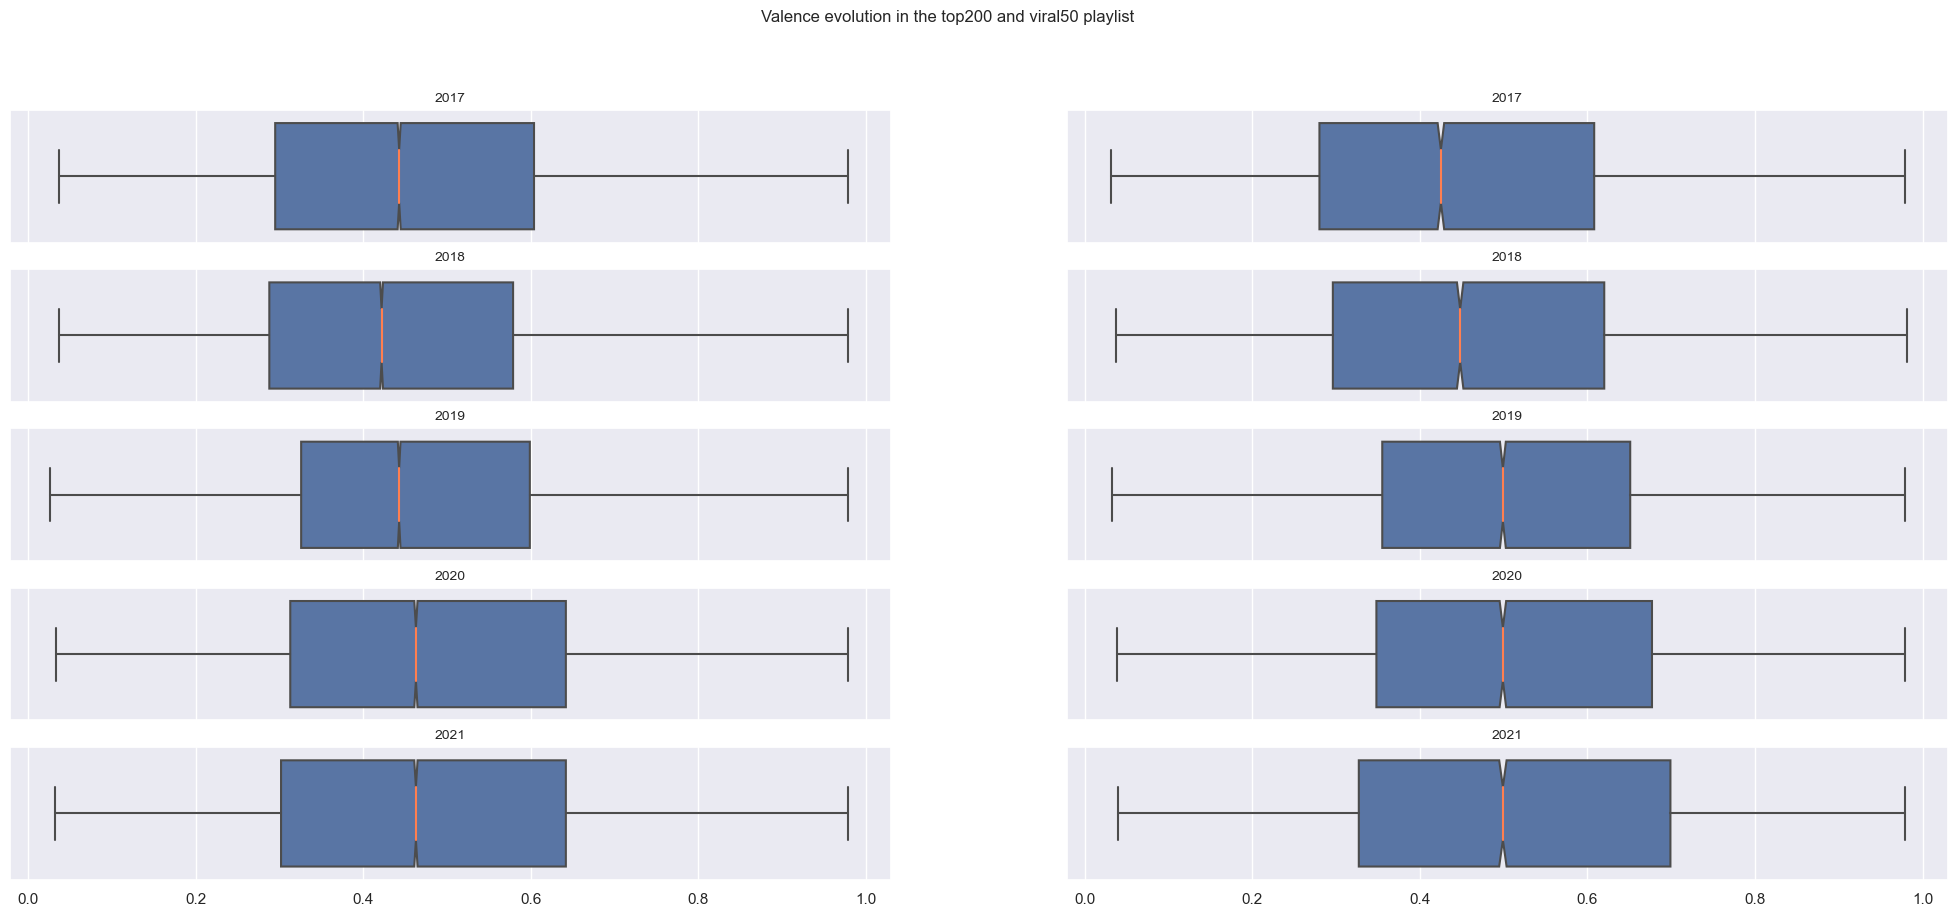

In [34]:
fig, axs = plt.subplots(ncols=2, nrows = len(top200.sort_values(by = ['playlist_date'])['playlist_date'].dt.year.unique().tolist()), figsize = (25, 10), sharex=True,)
list_years = top200.sort_values(by = ['playlist_date'])['playlist_date'].dt.year.unique().tolist()
sns.set_theme(style="darkgrid")
rows = [0, 1]
fig.suptitle('Valence evolution in the top200 and viral50 playlist', fontsize=12)
for year in list_years:
    for row in rows:
        if row == 0:
            #print(year, list_years.index(year))
            sns.boxplot(x=top200[top200['playlist_date'].dt.year == year].valence, data = top200[top200['playlist_date'].dt.year == year], medianprops={"color": "coral"}, notch=True,flierprops={"marker": "x"},
                ax=axs[list_years.index(year)][0]) ;
            axs[list_years.index(year)][0].set_title(str(year), fontsize=10, )
            axs[list_years.index(year)][0].set_xlabel("")
        elif row == 1:
            #print(year, list_years.index(year))
            sns.boxplot(x=viral50[viral50['playlist_date'].dt.year == year].valence, data = viral50[viral50['playlist_date'].dt.year == year], notch=True, flierprops={"marker": "x"},
                ax=axs[list_years.index(year)][1], medianprops={"color": "coral"}) ;
            axs[list_years.index(year)][1].set_title(str(year), fontsize=10, )
            axs[list_years.index(year)][1].set_xlabel("")

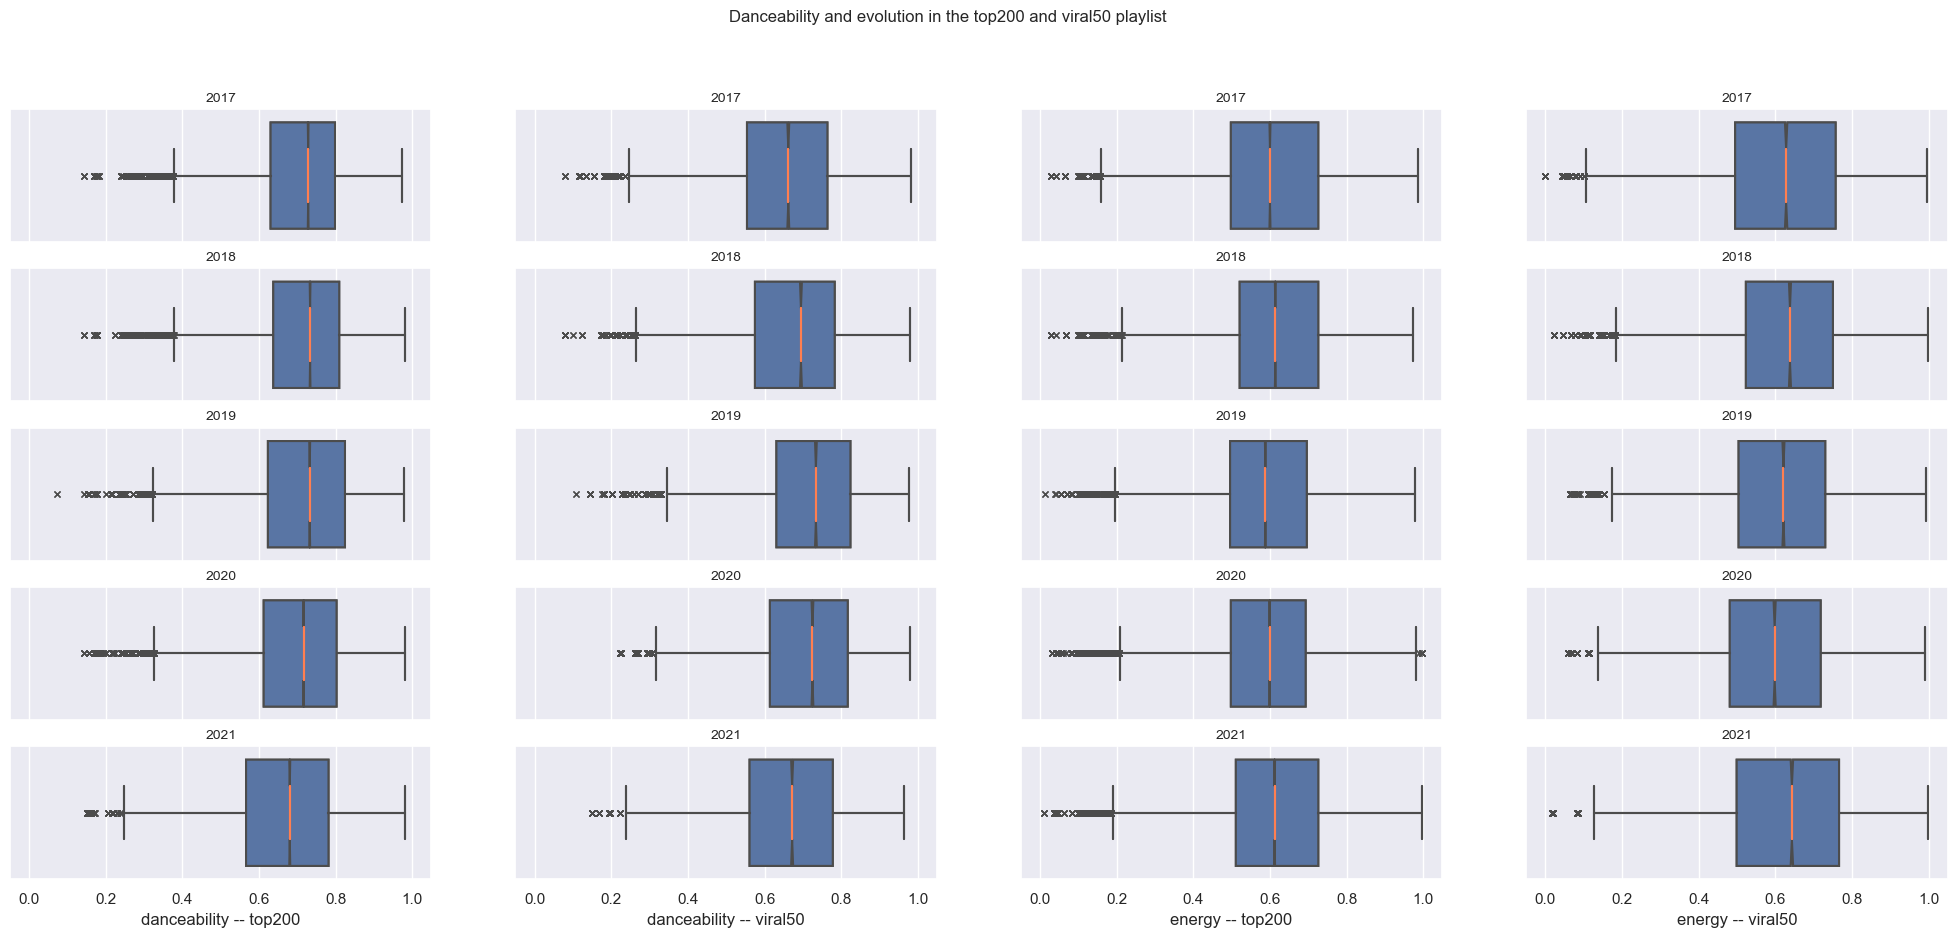

In [33]:
fig, axs = plt.subplots(ncols=4, nrows = len(top200.sort_values(by = ['playlist_date'])['playlist_date'].dt.year.unique().tolist()), figsize = (25, 10), sharex=True,)
list_years = top200.sort_values(by = ['playlist_date'])['playlist_date'].dt.year.unique().tolist()
sns.set_theme(style="darkgrid")
columns = [0, 1]
column_name = ['danceability', 'energy']
fig.suptitle('Danceability and evolution in the top200 and viral50 playlist', fontsize=12)
for year in list_years:
    for column in column_name:
        for row in list(range(0,4)):
            if row == 0:
                sns.boxplot(x=top200[top200['playlist_date'].dt.year == year].danceability, data = top200[top200['playlist_date'].dt.year == year], medianprops={"color": "coral"}, notch=True,flierprops={"marker": "x"}, 
                    ax=axs[list_years.index(year)][row]) ;
                axs[list_years.index(year)][row].set_title(str(year), fontsize=10, )
                if year == 2021:
                    axs[list_years.index(year)][row].set_xlabel("danceability -- top200")
                else:
                    axs[list_years.index(year)][row].set_xlabel("")
            elif row == 1:
                sns.boxplot(x=viral50[viral50['playlist_date'].dt.year == year].danceability, data = viral50[viral50['playlist_date'].dt.year == year], notch=True, flierprops={"marker": "x"}, 
                    ax=axs[list_years.index(year)][row], medianprops={"color": "coral"}) ;
                axs[list_years.index(year)][row].set_title(str(year), fontsize=10, )
                if year == 2021:
                    axs[list_years.index(year)][row].set_xlabel("danceability -- viral50")
                else:
                    axs[list_years.index(year)][row].set_xlabel("")
            elif row == 2:
                sns.boxplot(x=top200[top200['playlist_date'].dt.year == year].energy, data = top200[top200['playlist_date'].dt.year == year], medianprops={"color": "coral"}, notch=True,flierprops={"marker": "x"}, 
                    ax=axs[list_years.index(year)][row]) ;
                axs[list_years.index(year)][row].set_title(str(year), fontsize=10, )
                if year == 2021:
                    axs[list_years.index(year)][row].set_xlabel("energy -- top200")
                else:
                    axs[list_years.index(year)][row].set_xlabel("")
            elif row == 3:
                sns.boxplot(x=viral50[viral50['playlist_date'].dt.year == year].energy, data = viral50[viral50['playlist_date'].dt.year == year], notch=True, flierprops={"marker": "x"}, 
                    ax=axs[list_years.index(year)][row], medianprops={"color": "coral"}) ;
                axs[list_years.index(year)][row].set_title(str(year), fontsize=10, )
                if year == 2021:
                    axs[list_years.index(year)][row].set_xlabel("energy -- viral50")
                else:
                    axs[list_years.index(year)][row].set_xlabel("")

Looking at big picture, the covid-19 pandemic doesn't seem to have a toll on the music `valence`, `danceability` or `energy`. Let's look up the top genres:

In [14]:
top5_musicgenre = df.groupby(['music_genre'])['streams'].sum().reset_index().sort_values(by = 'streams', ascending = False).head(5)
top5_musicgenre['ratio'] = top5_musicgenre['streams'] * 100 / (df[~df['streams'].isnull()]['streams'].sum())
top5_musicgenre

,music_genre,streams,ratio
9,hip-hop,57273864611.000,39.909
17,pop,24813720044.000,17.290
18,rap,10241827649.000,7.137
25,trap,9038507811.000,6.298
20,rnb,7881291347.000,5.492


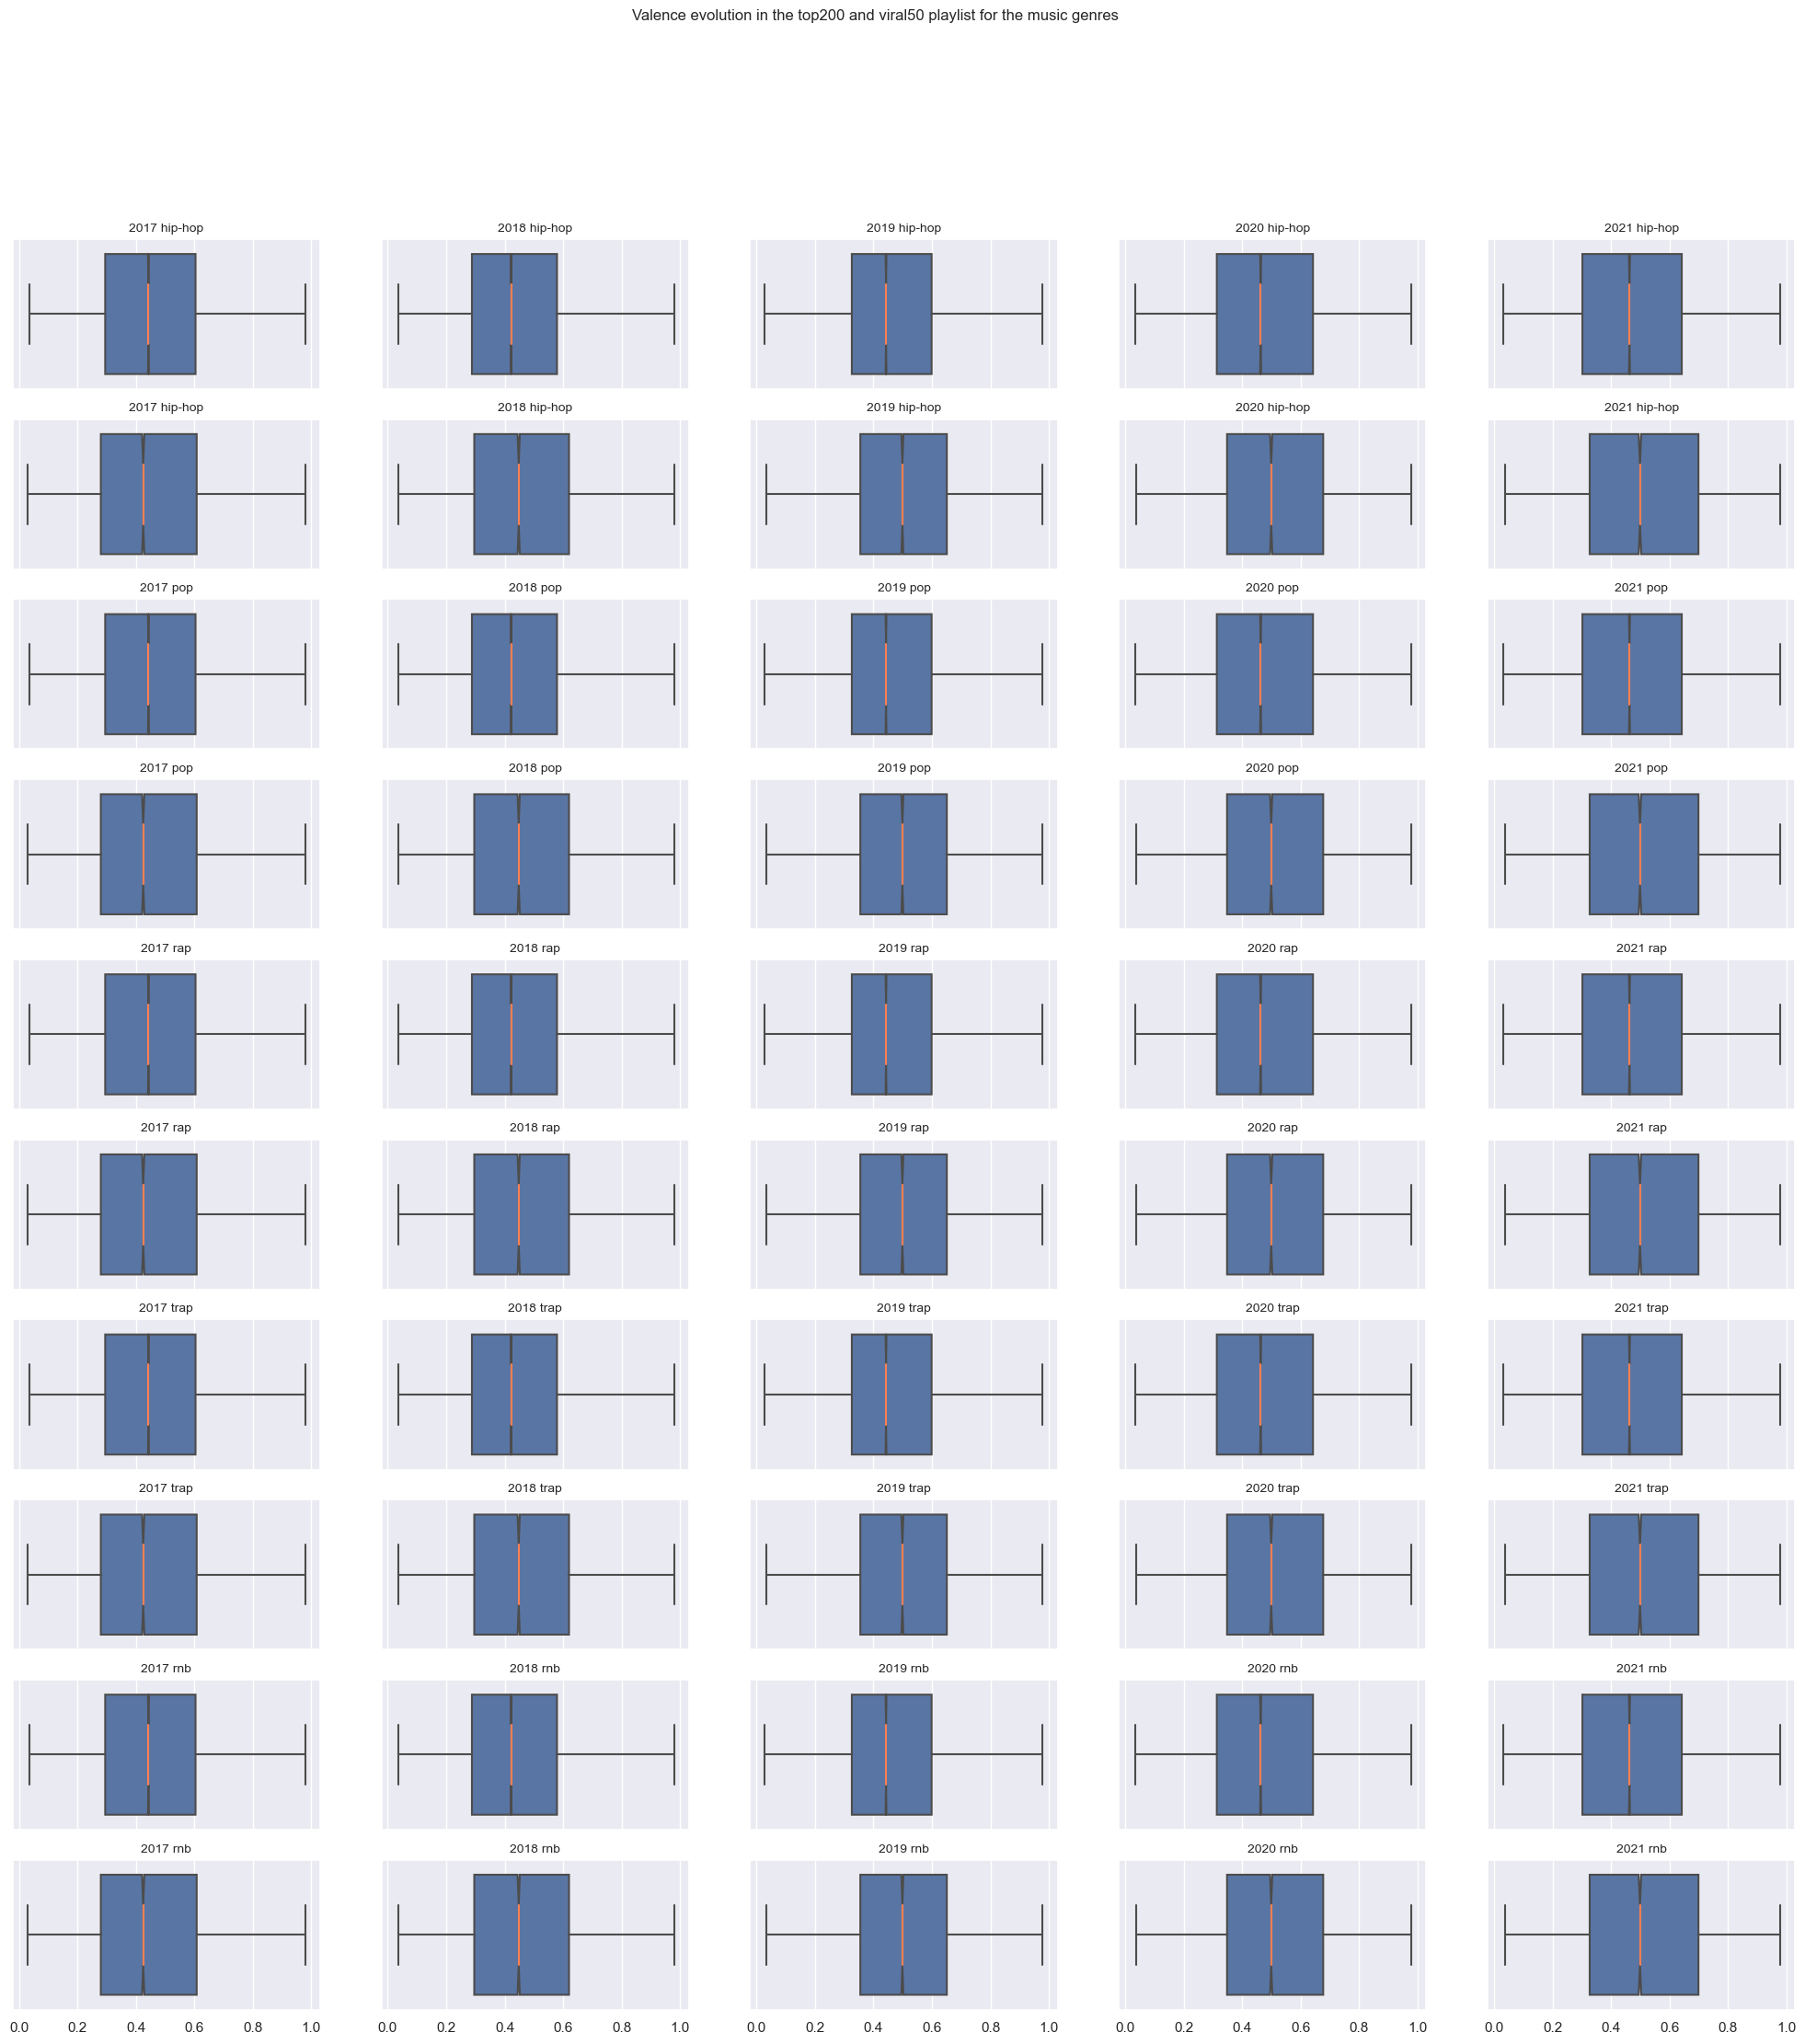

In [32]:
sns.set_theme(style="darkgrid")
genres = [val for val in top5_musicgenre['music_genre'].tolist() for _ in (0, 1)]
list_years = top200.sort_values(by = ['playlist_date'])['playlist_date'].dt.year.unique().tolist()
fig, axs = plt.subplots(ncols=len(list_years), nrows = len(genres), figsize = (25, 25), sharex=True,)

#axs = axs.flat
rows = [0, 1]
fig.suptitle('Valence evolution in the top200 and viral50 playlist for the music genres', fontsize=12)

for genre, row in zip(genres, list(range(0, 10))):
    for year in list_years:
        if row % 2 == 0:
            #print(genre, year, 'top200')
            sns.boxplot(x=top200[top200['playlist_date'].dt.year == year].valence, data = top200[top200['playlist_date'].dt.year == year], medianprops={"color": "coral"}, notch=True,flierprops={"marker": "x"}, orient='v',
                ax=axs[row][list_years.index(year)]) ;
            axs[row][list_years.index(year)].set_title(str(year) + ' ' + genre, fontsize=10, )
            axs[row][list_years.index(year)].set_xlabel("")
        elif row % 2 != 0:
            #print(genre, year, 'viral50')
            sns.boxplot(x=viral50[viral50['playlist_date'].dt.year == year].valence, data = viral50[viral50['playlist_date'].dt.year == year], notch=True, flierprops={"marker": "x"}, orient='v',
                ax=axs[row][list_years.index(year)], medianprops={"color": "coral"}) ;
            axs[row][list_years.index(year)].set_title(str(year) + ' ' + genre, fontsize=10, )
            axs[row][list_years.index(year)].set_xlabel("")

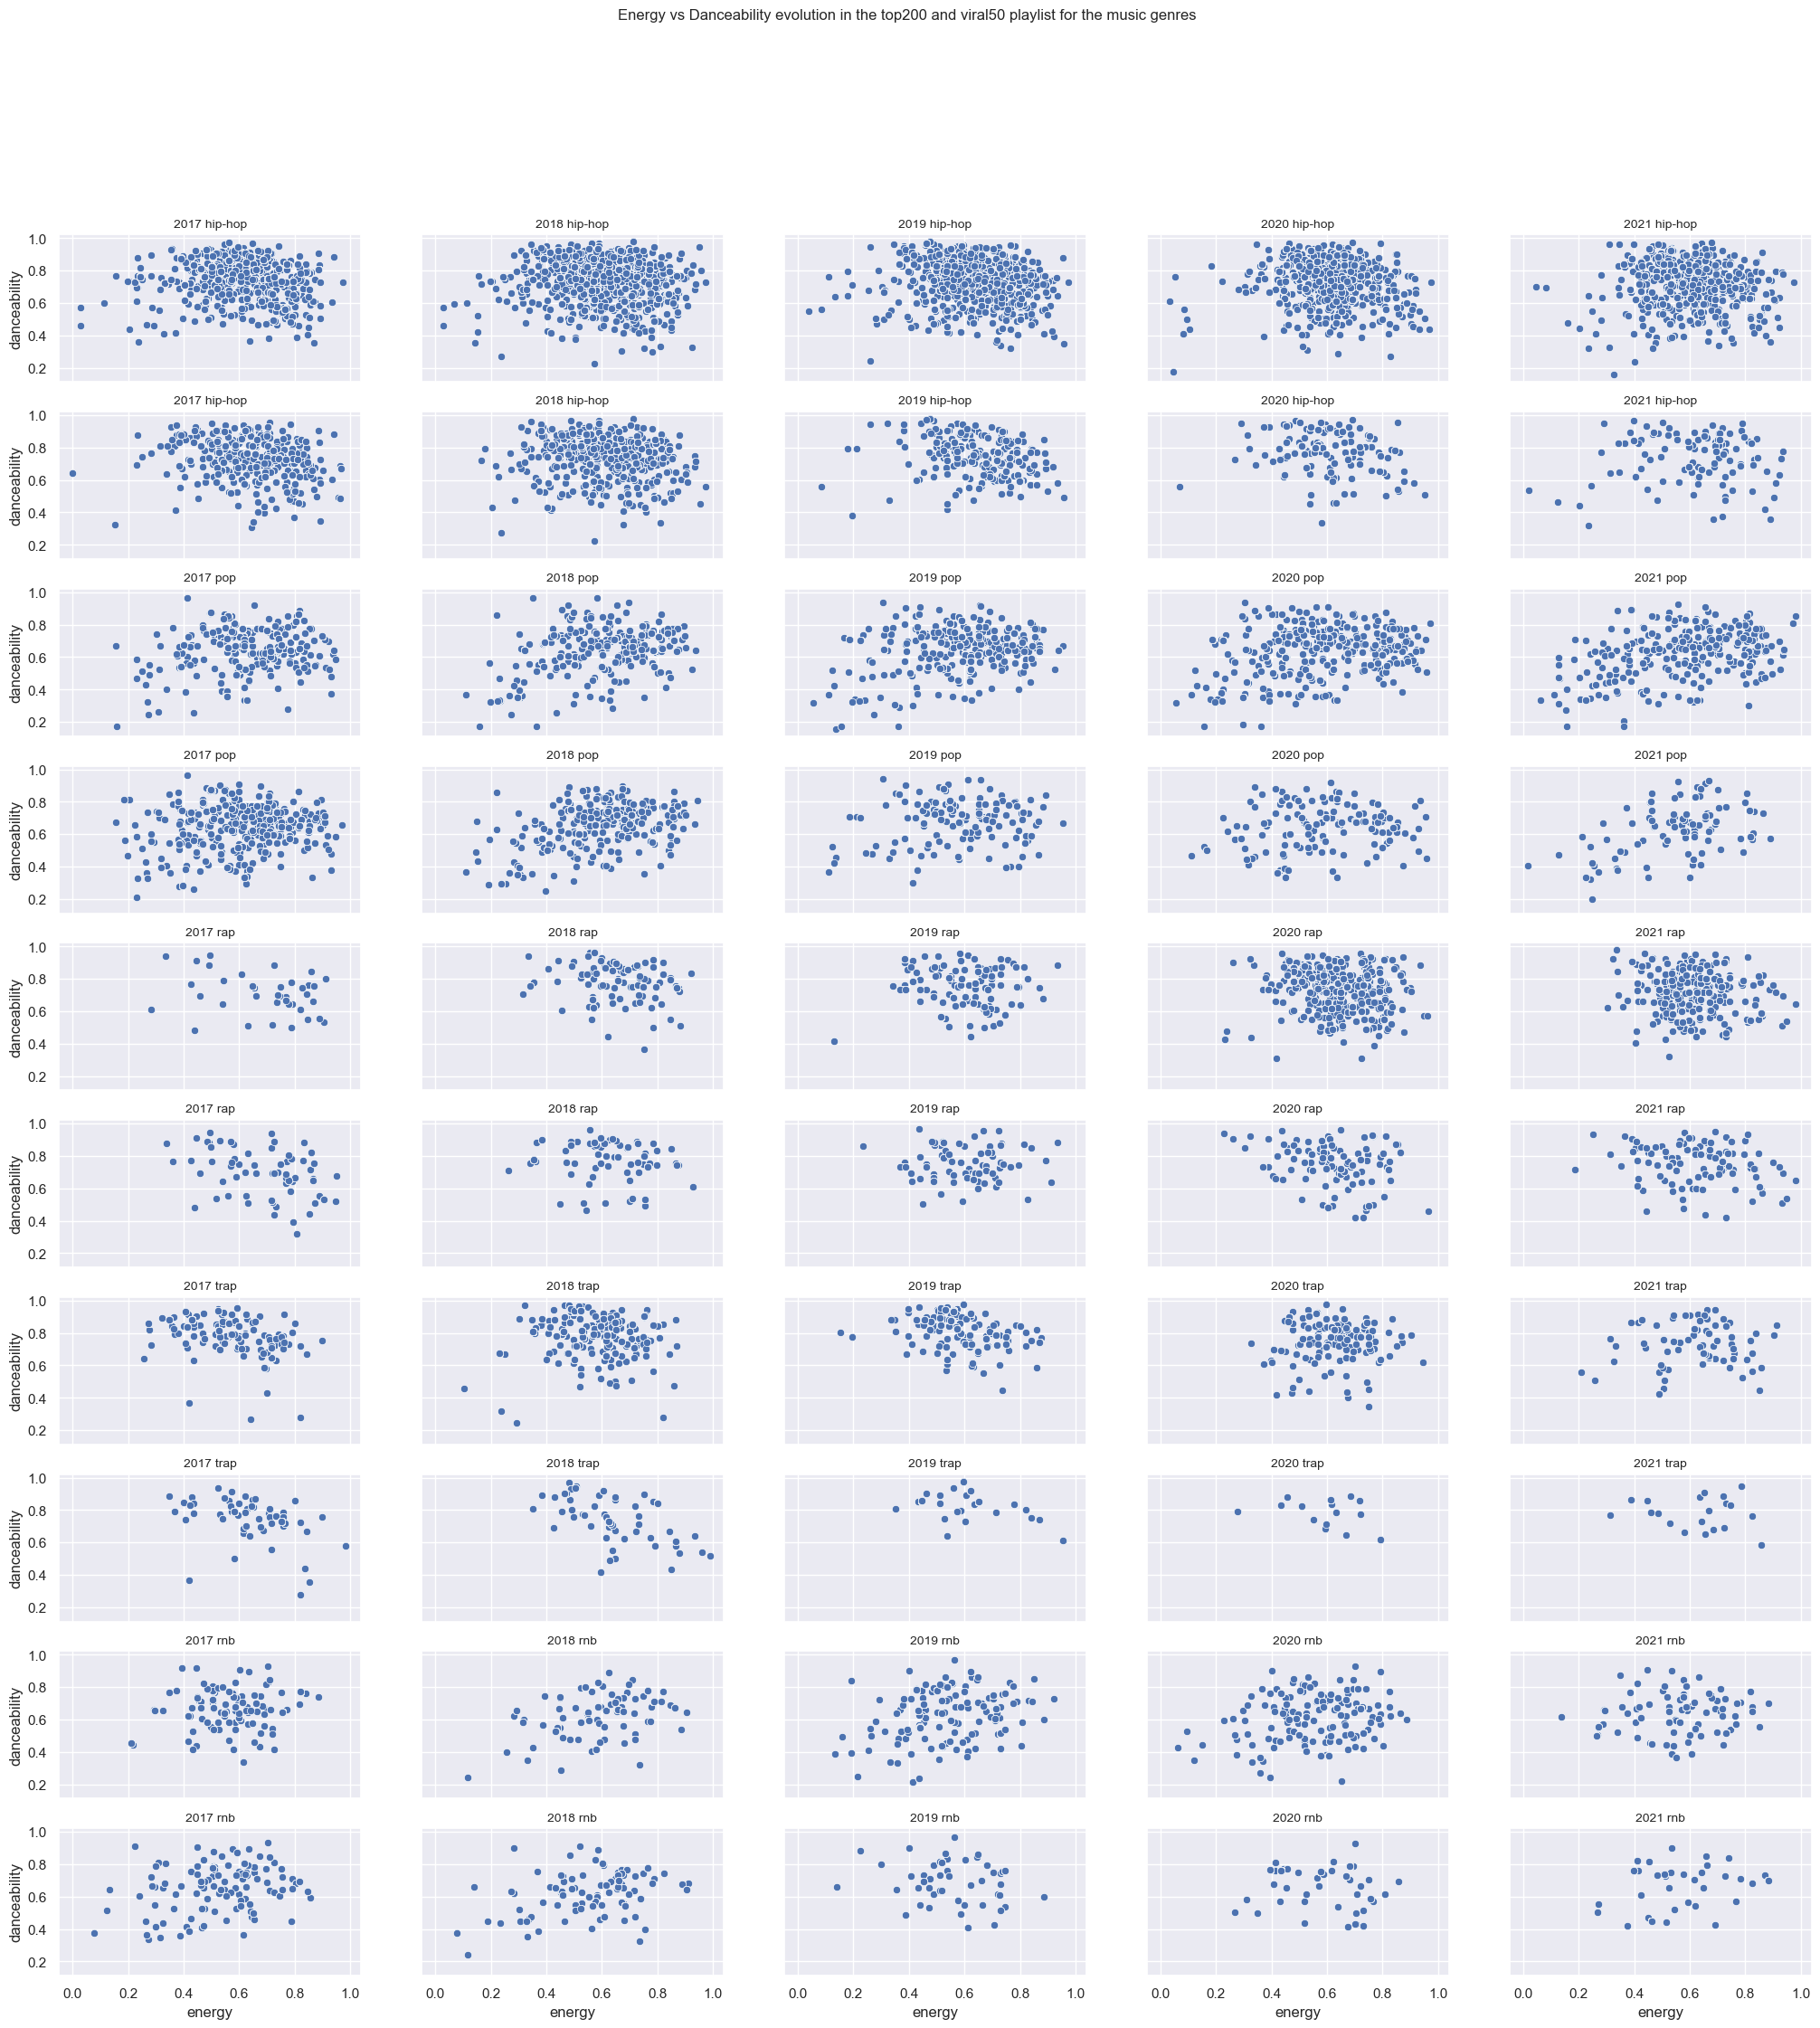

In [31]:
sns.set_theme(style="darkgrid")
list_years = top200.sort_values(by = ['playlist_date'])['playlist_date'].dt.year.unique().tolist()
fig, axs = plt.subplots(ncols=len(list_years), nrows = 10, figsize = (25, 25), sharex = True, sharey = True)
genres = [val for val in top5_musicgenre['music_genre'].tolist() for _ in (0, 1)]
fig.suptitle('Energy vs Danceability evolution in the top200 and viral50 playlist for the music genres', fontsize=12)
for genre, row in zip(genres, list(range(0, 10))):
        for year in list_years:
            if row % 2 == 0:
                sns.scatterplot(x = top200[(top200['playlist_date'].dt.year == year) & (top200['music_genre'] == genre)].energy, y = top200[(top200['playlist_date'].dt.year == year) & (top200['music_genre'] == genre)].danceability, 
                    ax=axs[row][list_years.index(year)]);
                axs[row][list_years.index(year)].set_title(str(year) + ' ' + genre, fontsize=10)
            elif row % 2 != 0:
                sns.scatterplot(x = viral50[(viral50['playlist_date'].dt.year == year) & (viral50['music_genre'] == genre)].energy, y = viral50[(viral50['playlist_date'].dt.year == year) & (viral50['music_genre'] == genre)].danceability, 
                    ax=axs[row][list_years.index(year)]);
                axs[row][list_years.index(year)].set_title(str(year) + ' ' + genre, fontsize=10)

Looking at the top 5 music genres, there also seems to be no change on the `valence`, `danceability` or `energy`.

In [17]:
top5_artist = df.groupby(['artist'])['streams'].sum().reset_index().sort_values(by = 'streams', ascending = False).head(5)
top5_artist['ratio'] = top5_artist['streams'] * 100 / (df[~df['streams'].isnull()]['streams'].sum())
top5_artist

,artist,streams,ratio
3638,Post Malone,4966682478.000,3.461
1293,Drake,4697961521.000,3.274
2273,Juice WRLD,4400300033.000,3.066
4923,XXXTENTACION,3436491646.000,2.395
587,Billie Eilish,2892423843.000,2.015


In [40]:
artist_top200 = top200[top200['artist'].isin(top5_artist['artist'].tolist())].groupby(['artist', 'year', 'month', 'date'])['valence', 'energy', 'danceability'].median().reset_index().sort_values(by=['year', 'month'], ascending = True)
artist_viral50 = viral50[viral50['artist'].isin(top5_artist['artist'].tolist())].groupby(['artist', 'year', 'month', 'date'])['valence', 'energy', 'danceability'].median().reset_index().sort_values(by=['year', 'month'], ascending = True)
artist_top200.head()

,artist,year,month,date,valence,energy,danceability
45,Drake,2017,1,2017-1,0.349,0.468,0.834
150,Post Malone,2017,1,2017-1,0.218,0.530,0.670
210,XXXTENTACION,2017,1,2017-1,0.349,0.726,0.763
46,Drake,2017,2,2017-2,0.349,0.468,0.834
151,Post Malone,2017,2,2017-2,0.218,0.530,0.670


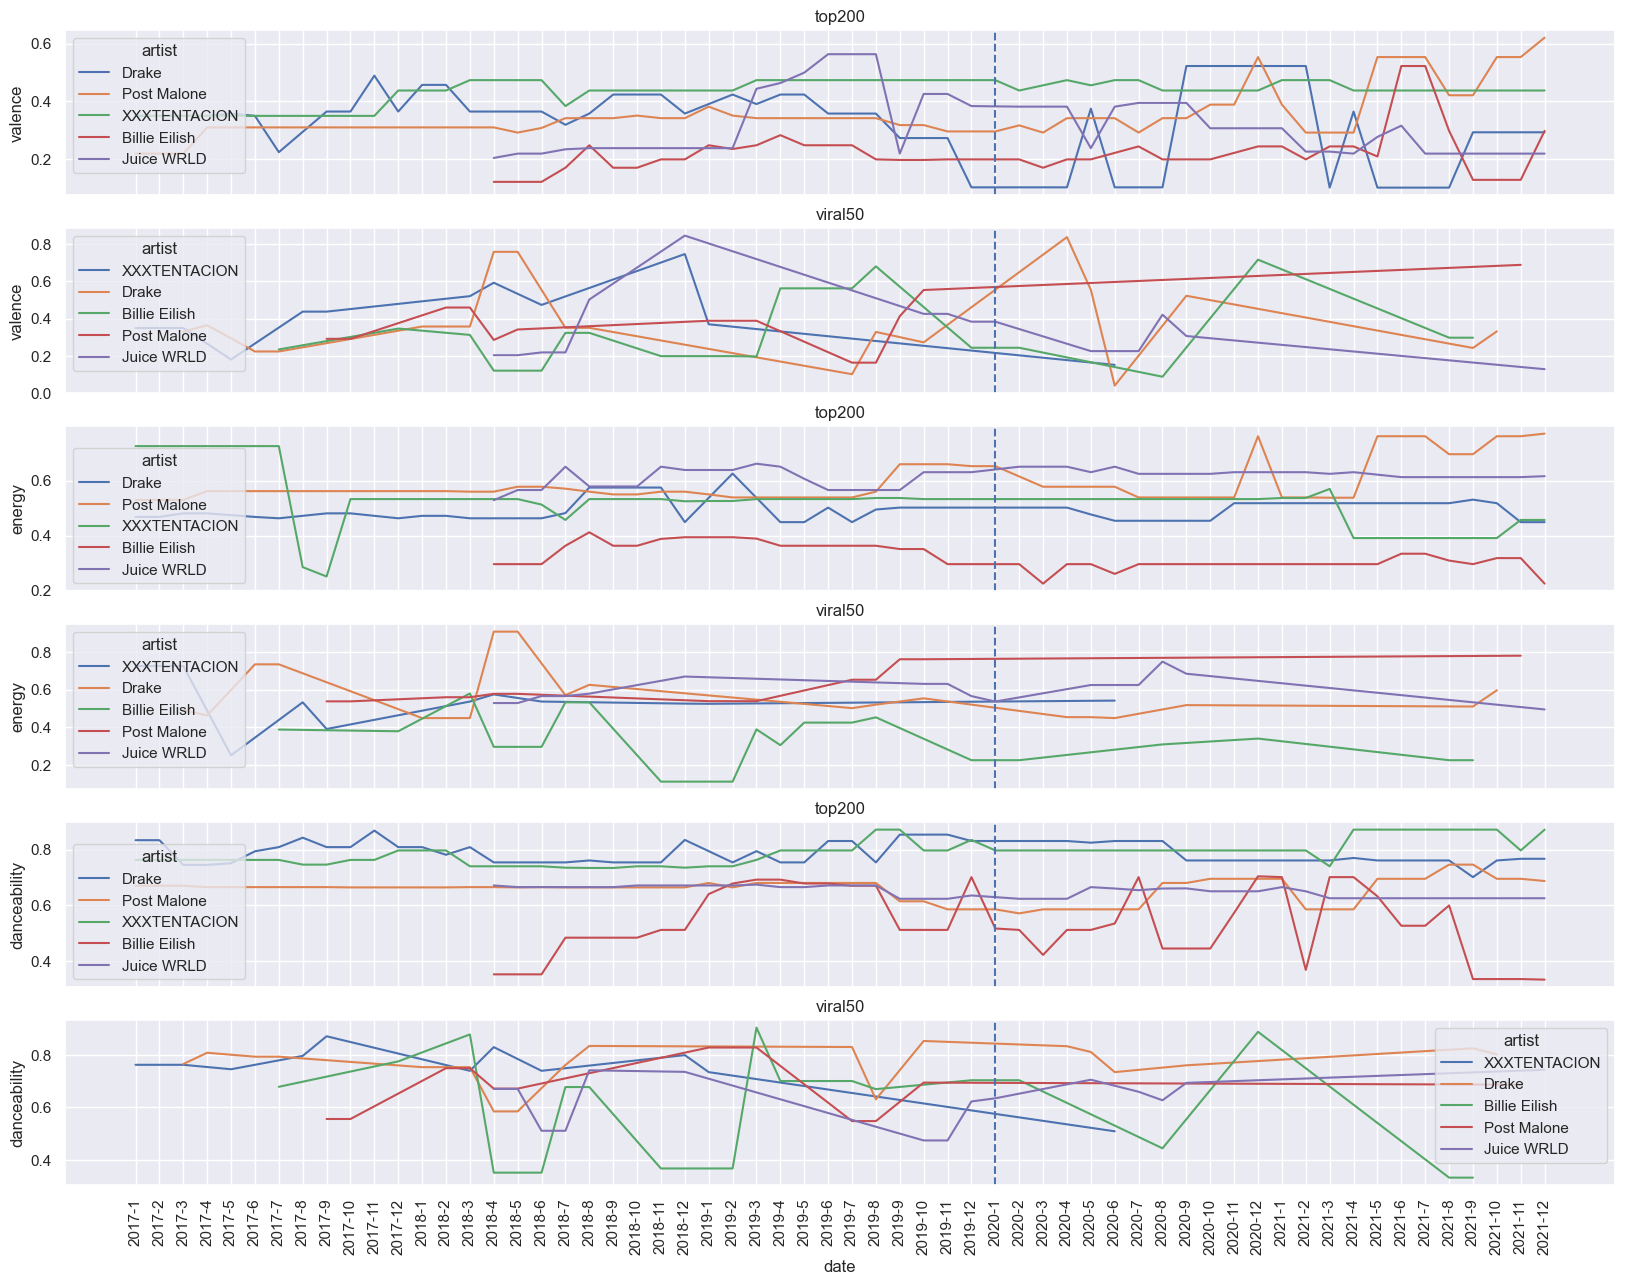

In [45]:
sns.set_theme(style="darkgrid")
#sns.set(rc={"figure.figsize":(25,10)})
fig, axs = plt.subplots(ncols=1, nrows = 6, figsize = (20, 15), sharex = True)
values = [val for val in ['valence', 'energy', 'danceability'] for _ in (0, 1)]
for row, value in zip(list(range(0,6)), values):
    if row % 2 == 0:
        sns.lineplot(x='date', y=value, hue="artist",  data=artist_top200, ax=axs[row])
        axs[row].set_title('top200')
        axs[row].axvline('2020-1', 0, 1, linestyle='dashed')
    elif row % 2 != 0:
        sns.lineplot(x='date', y=value, hue="artist",  data=artist_viral50 , ax=axs[row])
        axs[row].set_title('viral50')        
        axs[row].axvline('2020-1', 0, 1, linestyle='dashed')
        plt.xticks(rotation = 90);